# Graph Coloring with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve graph coloring problems with physics-inspired graph neural networks, as outlined in Martin J. A. Schuetz, J. Kyle Brubaker, Zhihuai Zhu, Helmut G. Katzgraber, _Graph Coloring with Physics-Inspired Graph Neural Networks_, [arXiv:2202.01606](https://arxiv.org/abs/2202.01606). 
Here we solve one example COLOR graph problem, but our approach can easily be extended to other problems, for instance the citations graphs. 
For the implementation of the graph neural network layers (GraphConv, GraphSAGE, etc) we use the open-source [```dgl``` library](https://github.com/dmlc/dgl/tree/0.9.x). 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3.7 --file requirements.txt -c dglteam

## Preliminaries

1. 
We include logic to determine whether to use CUDA (e.g. GPU) or CPU backend, but it's important to note that DGL library must be installed with CUDA drivers included or this script will fail. We include comments in `requirements.txt` on how to handle this, which we reproduce here for visibility:

```
# For CPU-based DGL installation (default option):
dgl

# For GPU-based DGL installation:
# DGL installation is complicated if you want to include CUDA (i.e. use GPUs)
# First, go to the terminal and look for the CUDA version, i.e. via `nvidia-smi`
# With that version, you can insert into the following command:
# `conda install -c dglteam dgl-cudaXY.Z`
# For instance, if CUDA version = 11.0:
# `conda install -c dglteam dgl-cuda11.0`
#dgl-cuda11.0

```

2. 
To help keep repository size low, we do not include the input dataset but provide command lines to download and unzip data files. The COLOR dataset can be downloaded from this site: https://mat.tepper.cmu.edu/COLOR/instances.html

    The direct download link to the `instances.tar` object is here: https://mat.tepper.cmu.edu/COLOR/instances/instances.tar

    We suggest downloading these files under the parent path `data/input/COLOR` and unpacking there, such that you have `queen5_5.col` and the path `data/input/COLOR/instances/queen5_5.col`. However, this is left to the user, and the parent path to file `queen5_5.col` (or whichever specific problem the user chooses) can be specified in the `input_parent` variable in **cell 3**
    
    You can unpack the tar file via any standard utility (i.e. by double-clicking on it) or via command line, such as (on linux) `tar -xvf instances.tar`

# Set Up Environment

In [1]:
import random
import torch
import warnings
import numpy as np
import networkx as nx
import os
import dgl

from time import time

warnings.filterwarnings('ignore')

Using backend: pytorch


In [2]:
# local imports: we load a few general utility functions from `minimal_utils.py`.

from minimal_utils import (
    get_adjacency_matrix, get_gnn, loss_func_color_hard, run_gnn_training,
    build_graph_from_color_file, chromatic_numbers
)

In [3]:
# fix seed to ensure consistent results
SEED_VALUE = 0
random.seed(SEED_VALUE)        # seed python RNG
np.random.seed(SEED_VALUE)     # seed global NumPy RNG
torch.manual_seed(SEED_VALUE)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Download COLOR datasets

Uncomment the following cells to download all the COLOR datasets. This only needs to be done once.

In [4]:
# # create directory for storing input data

# input_data_path = './data/input/COLOR/instances'
# if not os.path.exists(input_data_path):
#     os.makedirs(input_data_path)

In [5]:
# !wget https://mat.tepper.cmu.edu/COLOR/instances/instances.tar -P ./data/input/COLOR/

In [6]:
# !tar -xvf ./data/input/COLOR/instances.tar -C './data/input/COLOR/instances'

# Step 1 - Set hyperparameters

We provide a default set of model hypers. Feel free to modify these as desired. 

We also include general parameters such as tolerance and patience for early stopping, the layer aggregation specification (`layer_agg_type`) for GraphSAGE, and some tracking of problem definition (problem name, chromatic number).

In [7]:
# Specify the problem instance to solve and where to find the dataset(s) here:

problem_file = 'queen5_5.col'

input_parent = './data/input/COLOR/instances'

In [8]:
# Sample hyperparameters
if TORCH_DEVICE.type == 'cpu':  # example with CPU
    hypers = {
        'model': 'GraphConv',   # set either with 'GraphConv' or 'GraphSAGE'. It cannot take other input
        'dim_embedding': 64,
        'dropout': 0.1,
        'learning_rate': 0.0001,
        'hidden_dim': 64,
        'seed': SEED_VALUE
    }
else:                           # example with GPU
    hypers = {
        'model': 'GraphSAGE',
        'dim_embedding': 77,
        'dropout': 0.3784,
        'learning_rate': 0.02988,
        'hidden_dim': 32,
        'seed': SEED_VALUE
    }

# Default meta parameters
solver_hypers = {
    'tolerance': 1e-3,           # Loss must change by more than tolerance, or add towards patience count
    'number_epochs': int(5e4),   # Max number training steps
    'patience': 500,             # Number early stopping triggers before breaking loop
    'graph_file': problem_file,  # Which problem is being solved
    'layer_agg_type': 'mean',    # How aggregate neighbors sampled within graphSAGE
    'number_classes': chromatic_numbers[problem_file]
}

# Combine into a single set
hypers.update(solver_hypers)

# Step 2 - Load in problem and create graph

Load in problem definition from specified path. Variables `input_parent` and `problem_file` should be defined appropriately in cell 3.

In [9]:
# Establish full input location
input_fpath = os.path.join(input_parent, problem_file)

# Load in graph
nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')

# Get DGL graph from networkx graph
# Ensure relevant objects are placed onto proper torch device
dgl_graph = dgl.from_networkx(nx_graph)
dgl_graph = dgl_graph.to(TORCH_DEVICE)

Building graph from contents of file: ./data/input/COLOR/instances/queen5_5.col


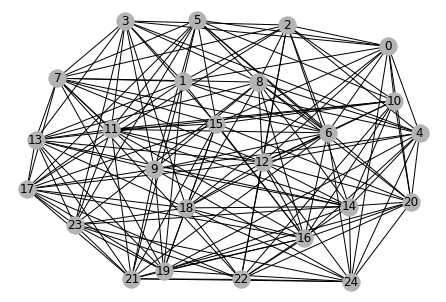

In [10]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

Instantiate optimizer and GNN objects with specified hypers.

In [11]:
# Retrieve known optimizer hypers
opt_hypers = {
    'lr': hypers.get('learning_rate', None)
}

# Get adjacency matrix for use in calculations
adj_ = get_adjacency_matrix(nx_graph, TORCH_DEVICE, TORCH_DTYPE)

# See minimal_utils.py for description. Constructs GNN and optimizer objects from given hypers. 
# Initializes embedding layer to use as initial model input
net, embed, optimizer = get_gnn(dgl_graph, nx_graph.number_of_nodes(), hypers, opt_hypers, TORCH_DEVICE, TORCH_DTYPE)

Function get_gnn(): Setting seed to 0
Building GraphConv model...
Building ADAM-W optimizer...


# Step 4 - Run GNN training

In [12]:
t_start = time()

probs, best_coloring, best_loss, final_coloring, final_loss, epoch_num = run_gnn_training(
    nx_graph, dgl_graph, adj_, net, embed, optimizer, hypers['number_epochs'], 
    hypers['patience'], hypers['tolerance'], seed=SEED_VALUE)

runtime_gnn = round(time() - t_start, 4)

# report results
print(f'GNN runtime: {runtime_gnn}s')

Function run_gnn_training(): Setting seed to 0
Epoch 0 | Soft Loss: 32.87294
Epoch 0 | Discrete Cost: 160.00000
Epoch 1000 | Soft Loss: 31.92066
Epoch 1000 | Discrete Cost: 21.00000
Epoch 2000 | Soft Loss: 28.51914
Epoch 2000 | Discrete Cost: 25.00000
Epoch 3000 | Soft Loss: 24.79060
Epoch 3000 | Discrete Cost: 20.00000
Epoch 4000 | Soft Loss: 21.68753
Epoch 4000 | Discrete Cost: 17.00000
Epoch 5000 | Soft Loss: 18.77556
Epoch 5000 | Discrete Cost: 17.00000
Epoch 6000 | Soft Loss: 13.72247
Epoch 6000 | Discrete Cost: 3.00000
Epoch 7000 | Soft Loss: 7.45258
Epoch 7000 | Discrete Cost: 0.00000
Epoch 8000 | Soft Loss: 3.65633
Epoch 8000 | Discrete Cost: 0.00000
Epoch 9000 | Soft Loss: 2.11171
Epoch 9000 | Discrete Cost: 0.00000
Epoch 10000 | Soft Loss: 0.81238
Epoch 10000 | Discrete Cost: 0.00000
Epoch 11000 | Soft Loss: 0.54176
Epoch 11000 | Discrete Cost: 0.00000
Epoch 12000 | Soft Loss: 0.28499
Epoch 12000 | Discrete Cost: 0.00000
Epoch 13000 | Soft Loss: 0.15844
Epoch 13000 | Discrete

# Step 5 - Post-process GNN results

Print the out cost of best solution (with minimum cost value) found during training.

In [13]:
# check for color violations
best_cost_hard = loss_func_color_hard(best_coloring, nx_graph)

print(f'Best (hard) cost of coloring (n_class={hypers["number_classes"]}): {best_cost_hard}')

Best (hard) cost of coloring (n_class=5): 0


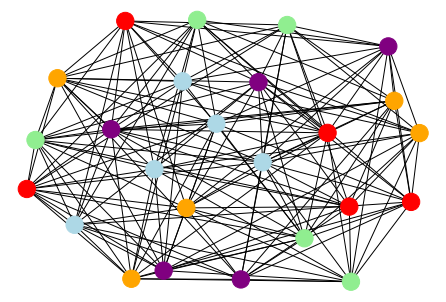

In [14]:
# Visualize result
color_dict = {0:'orange', 1:'lightblue', 2:'purple', 3:'red', 4:'lightgreen'}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map)